# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import numpy as np 
import pandas as pd  
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.linear_model import LinearRegression 
from catboost import Pool, CatBoostRegressor, cv
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

import lightgbm as lgb 
import catboost as cb

from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split 

from sklearn.metrics import make_scorer, mean_squared_error 

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/datasets/autos.csv') 

In [3]:
display(df.head(10))
df.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Вывод

- Есть пропуски в столбцах: 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired'.
- Некорректные типы данных в столбцах: 'DateCrawled', 'DateCreated'
- Названия колонок в верхнем регистре
- Датафрейм состоит из следующих столбцов:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- Price — цена (евро)

Для обучения модели выделим:

- Признаки: VehicleType, RegistrationYear, Gearbox, Power, Model, Kilometer, RegistrationMonth, FuelType, Brand, NotRepaired
- Целевой признак: Price — цена (евро)

#### Датасет изучен

In [4]:
print(df['Model'].unique())

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper' 'leon'
 '4

#### Среди значений столбца 'Model' имеются такие как other. Используем их для заполнения пропусков в этом столбце.

In [5]:
df['Model'] = df['Model'].fillna('other')

#### Посмотрим данные в других столбцах:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              354369 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
print(df['Gearbox'].value_counts())
print(df['Repaired'].value_counts())
print(df['FuelType'].value_counts())
print(df['VehicleType'].value_counts())

manual    268251
auto       66285
Name: Gearbox, dtype: int64
no     247161
yes     36054
Name: Repaired, dtype: int64
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64


#### Пропуски данных в столбцах 'Gearbox' и 'NotRepaired' заполним новой категорией 'unknown':

In [8]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Repaired'] = df['Repaired'].fillna('unknown')

#### Для заполнения пропусков в столбцах 'VehicleType' и 'FuelType' используем данные из других строк с таким же значением в столбце 'Model'. Напишем функцию для заполнения пропусков в столбцах, на вход она принимает датафрейм, столбец с моделями авто и стобец, который нужно заполнить. Применим функцию:

In [9]:
def type_filling_func(dataframe, model_column, type_column):
    model_list = list(dataframe[model_column].unique())
    type_list = []
    for i in model_list:
        type_list.append(list(dataframe.loc[dataframe.loc[:,model_column] == i][type_column].mode())[0])
    model_dict = dict(zip(model_list, type_list))
    
    for i in model_dict:
        dataframe.loc[dataframe.loc[:,model_column] == i] = dataframe.loc[dataframe.loc[:,model_column] == i].fillna(model_dict[i])
type_filling_func(df, 'Model', 'VehicleType')
type_filling_func(df, 'Model', 'FuelType')

#### Посмотрим результаты предобработки

In [10]:
df.info()
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        354369 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            354369 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              354369 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           354369 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           354369 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,unknown,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,sedan,volkswagen,unknown,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


#### Создаем список столбцов с данными типа int64:

In [11]:
numeric = []
for i in df.columns:
    if df[i].dtypes == 'int64':
        numeric.append(i)

print(numeric)

['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode']


#### Строим диаграммы размаха (aka "Ящик с усами") по столбцам с данными типа int64:

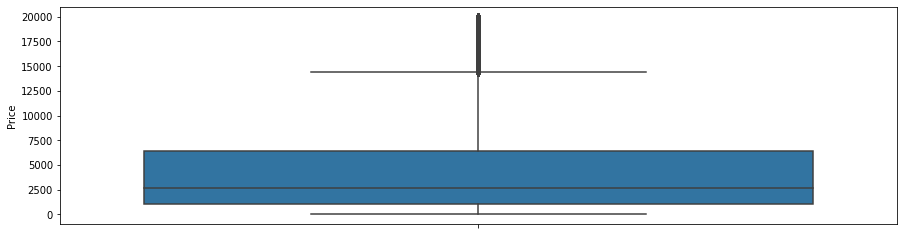

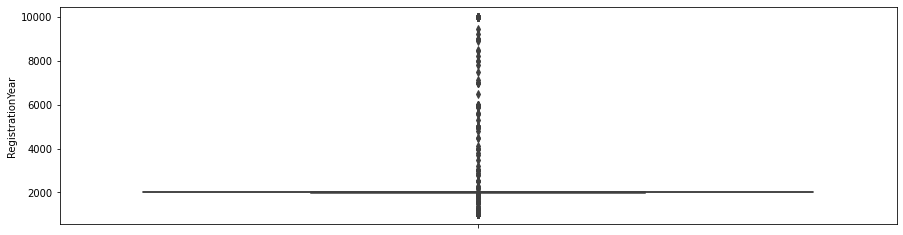

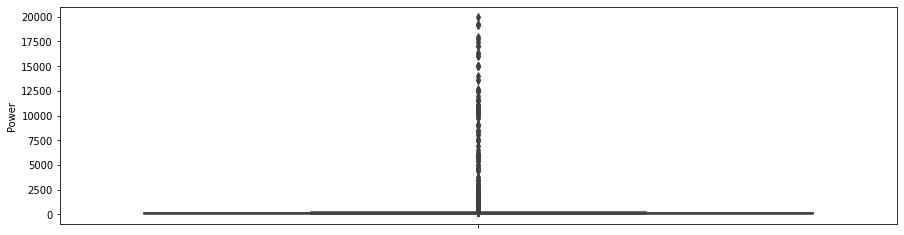

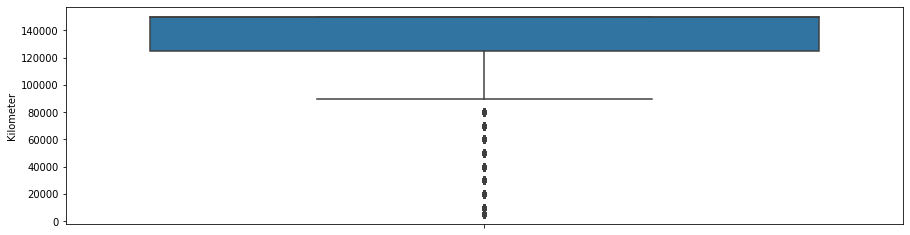

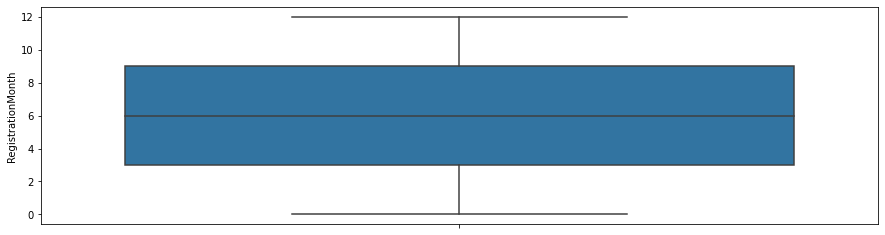

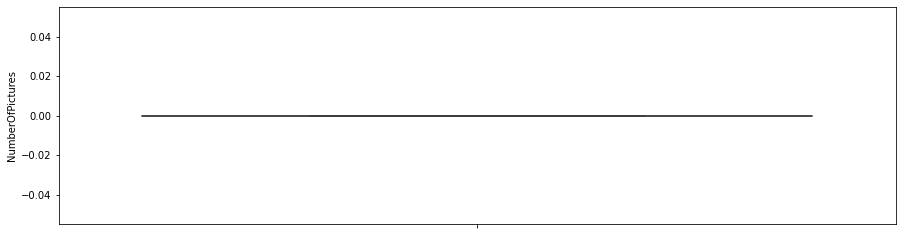

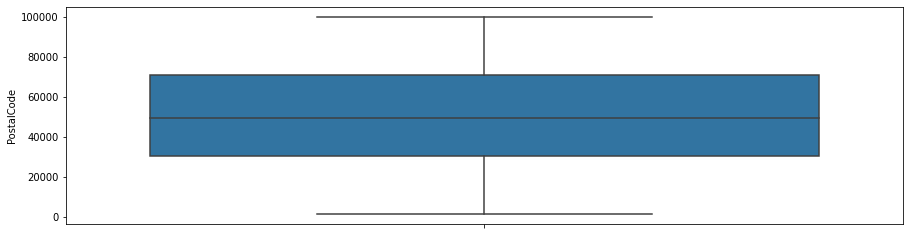

In [12]:
for i in numeric:
    plt.figure(figsize=(15, 4))
    sns.boxplot(y=i, data=df, orient="h")

#### Строим гистограммы по столбцам с данными типа int64:

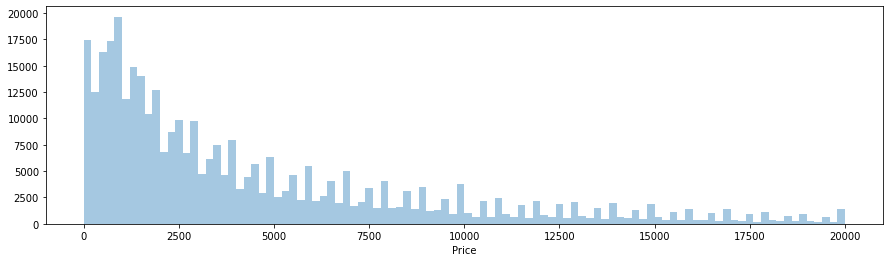

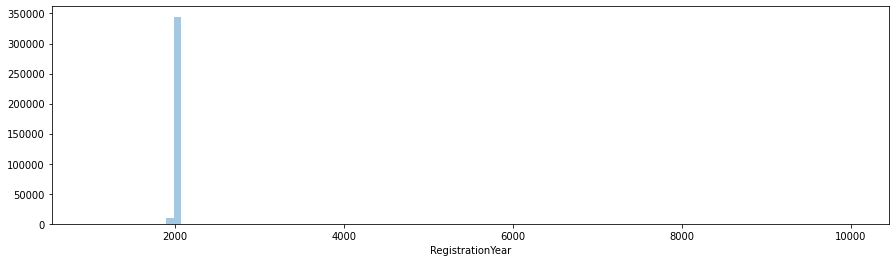

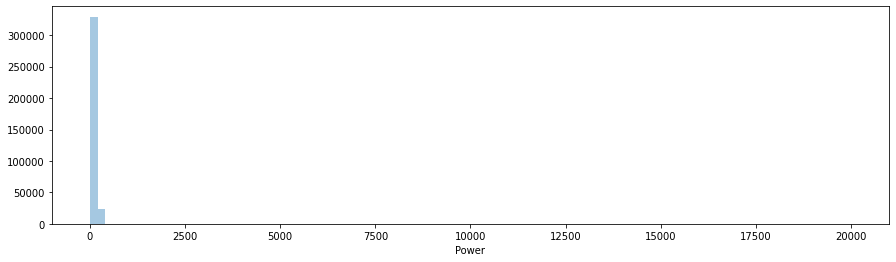

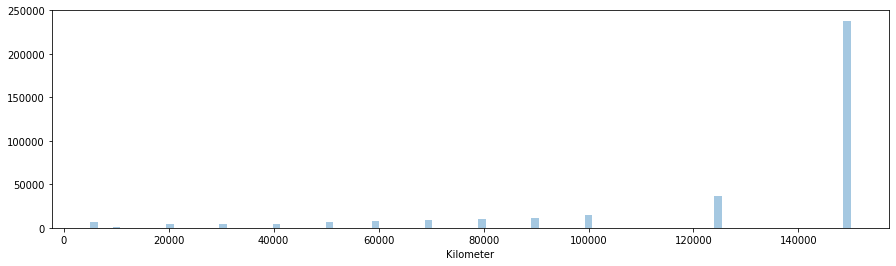

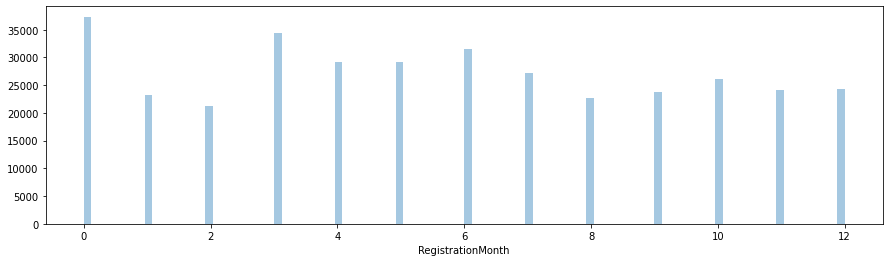

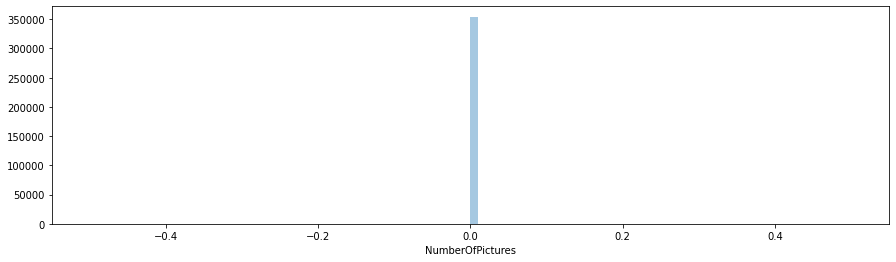

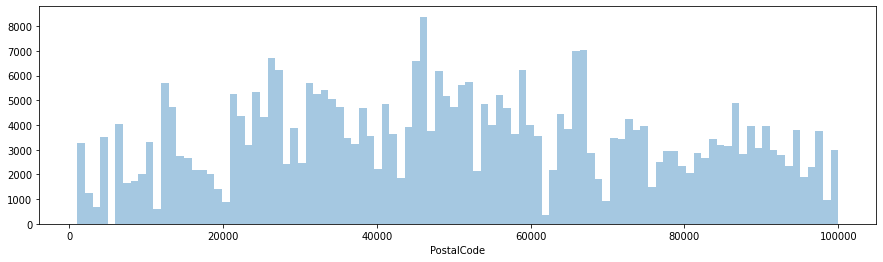

In [13]:
for i in numeric:
    plt.figure(figsize=(15, 4))
    sns.distplot(df[i], kde=False, bins=100)

#### Посмотрим на столбцы которые нам интересны:

In [14]:
print(sorted(df['RegistrationYear'].unique()))
print()
print(df['Power'].describe())
print()
print(df['Price'].describe())

[1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500, 1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8455, 8500, 8888, 9000, 9229, 9450, 9996, 9999]

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000


#### Из описаний столбцов, боксплотов и гистограмм видно, что в столбцах 'Price', 'RegistrationYear', 'Power' есть аномальные значения. Например, нулевые и близкие к нулю значения в столбцах 'Power' и 'Price', в столбце 'RegistrationYear' также обнаружены аномальные значения.

#### Чтобы точнее определить верхнюю границу для столбца 'RegistrationYear', найдем самую позднюю дату в столбце 'DateCreated':

In [15]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d')
print(df['DateCreated'].max())
print(df['DateCreated'].dt.year.max())

2016-04-07 00:00:00
2016


#### Удалим аномальные значения из датасета. Оставим автомобили с регистрацией не позднее 2016 и не ранее 1960 года (антиквариат и машины из будущего пусть продаются на других площадках). Мощность двигателей ограничим значениями 10 < P < 1000 л.с. Минимальную цену выставим 100 евро.

In [16]:
df = df.loc[(df['RegistrationYear'] < df['DateCreated'].dt.year.max()) & 
                (df['RegistrationYear'] > 1960) &
                (df['Power'] < 1000) &
                (df['Power'] > 10) &
                (df['Price'] > 100)
               ]

#### Удалим ненужные для обучения моделей столбцы:

In [17]:
df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis='columns', inplace=True)

#### Посмотрим на итоговый DataFrame:

In [18]:
df.info()
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288174 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              288174 non-null  int64 
 1   VehicleType        288174 non-null  object
 2   RegistrationYear   288174 non-null  int64 
 3   Gearbox            288174 non-null  object
 4   Power              288174 non-null  int64 
 5   Model              288174 non-null  object
 6   Kilometer          288174 non-null  int64 
 7   RegistrationMonth  288174 non-null  int64 
 8   FuelType           288174 non-null  object
 9   Brand              288174 non-null  object
 10  Repaired           288174 non-null  object
dtypes: int64(5), object(6)
memory usage: 26.4+ MB


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,0,sedan,volkswagen,unknown
10,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes


In [19]:
df.duplicated().sum()

22970

In [20]:
# Удаляем дубликаты
df.drop_duplicates(inplace=True)

In [21]:
df.duplicated().sum()

0

#### Дубликатов после удаления призаков не обнаружено

### Вывод

    На первом этапе произведена загрузка данных и их подготовка для обучения моделей. Для анализа данных и построения модели предоставлен датасет, содержащий информацию о технических характеристиках, комплектациях и ценах автомобилей, которые размещались на площадке сервиса «Не бит, не крашен» для продажи. Датасет состоит из 16 столбцов с данными и 354369 строк. Пропуски данных были в столбцах 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired'. Для обучения моделей требовалась подготовка данных.

- В столбце 'Model' значения NaN были заменены на other.
- Пропуски данных в столбцах 'Gearbox' и 'Repaired' заполнены ниболее часто встречающимся значением случйной величины. Для заполнения пропусков в столбцах 'VehicleType' и 'FuelType' использованы данные из других строк с таким же значением в столбце 'Model'.
- Построена диаграмм размаха и определены аномальные значения в столбцах 'RegistrationYear' и 'Power',удалены лишние строки с этими значениями.
- Финальным этапом предобработки данных стало удаление ненужных для обучения моделей столбцов, а именно - 'DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'.

В итоге получен датасет, состоящий из 11 столбцов с данными и 288174 строк.

Можно приступать к обучению моделей.

## Обучение моделей

- Подготовьте выборки для обучения моделей.
- Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры

In [22]:
cat_columns = ['VehicleType', 'Gearbox', 'Brand', 'Model', 'FuelType', 'RegistrationYear', 'Repaired']
number = ['Power', 'Kilometer']

In [23]:
features=df.drop(['Price'],axis=1)
target=df['Price']

In [24]:
#Обуч и тест выборка
features_train, features_test, target_train, target_test = train_test_split(features,target, test_size=0.25, random_state=1515)

In [25]:
features_train=features_train.reset_index(drop=True)
features_test=features_test.reset_index(drop=True)

In [26]:
from sklearn.preprocessing import OrdinalEncoder
#Преобразовываем категориальные признаки с помощью OrdinalEncoder
encoder = OrdinalEncoder()
encoder.fit(features_train[cat_columns])
original_features_train = features_train.copy()
original_features_test = features_test.copy()
original_features_train[cat_columns]= encoder.transform(features_train[cat_columns])
original_features_test[cat_columns]= encoder.transform(features_test[cat_columns])
display(original_features_train.head())
original_features_test.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,7.0,38.0,1.0,136,233.0,150000,5,9.0,24.0,1.0
1,5.0,37.0,1.0,58,166.0,150000,3,9.0,27.0,2.0
2,7.0,45.0,0.0,200,170.0,125000,7,9.0,38.0,0.0
3,1.0,49.0,1.0,109,8.0,150000,10,9.0,25.0,0.0
4,4.0,48.0,0.0,177,6.0,150000,3,5.0,2.0,2.0


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,4.0,39.0,1.0,136,11.0,150000,1,5.0,2.0,0.0
1,4.0,46.0,1.0,109,33.0,150000,7,10.0,20.0,0.0
2,5.0,35.0,1.0,174,116.0,150000,10,9.0,38.0,2.0
3,7.0,46.0,1.0,102,116.0,125000,7,9.0,38.0,0.0
4,3.0,54.0,2.0,500,166.0,50000,4,5.0,1.0,1.0


In [27]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
#OHE кодирование
ohe = OneHotEncoder(handle_unknown='error', drop='first')
ohe.fit(features_train[cat_columns])
ohe_train = pd.DataFrame(ohe.transform(features_train[cat_columns]).toarray())
ohe_test = pd.DataFrame(ohe.transform(features_test[cat_columns]).toarray())
ohe_train.columns=ohe.get_feature_names()
ohe_test.columns=ohe.get_feature_names()
ohe_features_train = features_train.join(ohe_train)
ohe_features_test = features_test.join(ohe_test)
ohe_features_train.drop(cat_columns, axis=1, inplace=True)
ohe_features_test.drop(cat_columns, axis=1, inplace=True)
display(ohe_features_train.head())
ohe_features_test.head()

,Power,Kilometer,RegistrationMonth,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,...,x5_2008,x5_2009,x5_2010,x5_2011,x5_2012,x5_2013,x5_2014,x5_2015,x6_unknown,x6_yes
0,136,150000,5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,58,150000,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,200,125000,7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,109,150000,10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,177,150000,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,Power,Kilometer,RegistrationMonth,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_wagon,...,x5_2008,x5_2009,x5_2010,x5_2011,x5_2012,x5_2013,x5_2014,x5_2015,x6_unknown,x6_yes
0,136,150000,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,109,150000,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,174,150000,10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,102,125000,7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,500,50000,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


#### Линейная регрессия

In [28]:
%%time

regressor = LinearRegression()
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR = (cross_val_score(regressor, 
                             ohe_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 2052.3665706688903
CPU times: user 2min 7s, sys: 2min 7s, total: 4min 15s
Wall time: 4min 15s


#### DecissionTree регрессия

In [29]:
%%time

# Модель на признаках, закодированных по методу OHE


regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 10)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[1515]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(original_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ohe = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 9, 'random_state': 1515}

Grid scores on development set:

3098.904990 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 1515}
2750.878325 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 1515}
2494.519412 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 1515}
2331.085922 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 1515}
2220.575009 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 1515}
2131.812514 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 1515}
2055.347663 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 1515}
1988.436415 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 1515}

CPU times: user 9.83 s, sys: 144 ms, total: 9.97 s
Wall time: 9.98 s


#### Регрессия CatBoostRegressor

In [30]:
%%time

# Модель на данных, закодированных по методу OE

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[1515],
                'verbose':[False]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(original_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.5, 'random_state': 1515, 'verbose': False}

Grid scores on development set:

1568.134243 for {'learning_rate': 0.1, 'random_state': 1515, 'verbose': False}
1562.616348 for {'learning_rate': 0.5, 'random_state': 1515, 'verbose': False}
1600.993256 for {'learning_rate': 0.8, 'random_state': 1515, 'verbose': False}

CPU times: user 6min 46s, sys: 5.16 s, total: 6min 51s
Wall time: 7min 14s


#### Обучаем ансамбль моделей LGBMRegressor:

In [31]:
%%time

regressor = lgb.LGBMRegressor() 
hyperparams = [{'num_leaves':[11, 50, 100], 
                'learning_rate':[0.3],
                'random_state':[1515]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(original_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 1515}

Grid scores on development set:

1661.727247 for {'learning_rate': 0.3, 'num_leaves': 11, 'random_state': 1515}
1581.459130 for {'learning_rate': 0.3, 'num_leaves': 50, 'random_state': 1515}
1567.808716 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 1515}

CPU times: user 16min 36s, sys: 9.45 s, total: 16min 46s
Wall time: 16min 51s


#### Определяем оптимальные гиперпараметры и качество модели на кросс-валидации:

### Линейная регрессия

In [32]:
%%time

model = LinearRegression()
model.fit(ohe_features_train, target_train)

CPU times: user 26.4 s, sys: 21.5 s, total: 48 s
Wall time: 47.9 s


LinearRegression()

In [33]:
%%time

target_predict = model.predict(ohe_features_test)
final_RMSE_LR = mean_squared_error(target_test, target_predict) ** 0.5

CPU times: user 128 ms, sys: 110 ms, total: 237 ms
Wall time: 210 ms


#### DecisionTree регрессия

In [34]:
%%time

# Модель на принаках, закодированных по методу OHE
model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=15, 
                              random_state=1515) 
model.fit(original_features_train, target_train)

CPU times: user 651 ms, sys: 5.45 ms, total: 656 ms
Wall time: 654 ms


DecisionTreeRegressor(max_depth=15, random_state=1515)

In [35]:
%%time
target_predict = model.predict(original_features_test)

CPU times: user 21 ms, sys: 163 µs, total: 21.2 ms
Wall time: 19.5 ms


In [36]:
final_RMSE_DTR_ohe = mean_squared_error(target_test, target_predict) ** 0.5 

In [37]:
%%time

# Модель на принаках, закодированных по методу OE
model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=13, 
                              random_state=1515) 
model.fit(original_features_train, target_train)

CPU times: user 605 ms, sys: 1.67 ms, total: 607 ms
Wall time: 606 ms


DecisionTreeRegressor(max_depth=13, random_state=1515)

In [38]:
%%time

target_predict = model.predict(original_features_test)

CPU times: user 17.3 ms, sys: 184 µs, total: 17.5 ms
Wall time: 15.7 ms


In [39]:
final_RMSE_DTR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5  

#### CatBoost регрессия

In [40]:
%%time

# Модель на данных, закодированных по методу OE
model = CatBoostRegressor(learning_rate=0.5, 
                          random_state=1515, 
                          verbose=False) 
model.fit(original_features_train, target_train)

CPU times: user 30.9 s, sys: 230 ms, total: 31.1 s
Wall time: 32.2 s


In [41]:
%%time

target_predict = model.predict(original_features_test)

CPU times: user 87.5 ms, sys: 4.08 ms, total: 91.6 ms
Wall time: 89.3 ms


In [42]:
final_RMSE_CBR_ordinal = mean_squared_error(target_test, target_predict) ** 0.5

#### LGBM регрессия

In [43]:
%%time

model = lgb.LGBMRegressor(learning_rate=0.1, 
                      num_leaves=100, 
                      random_state=1515)
model.fit(original_features_train, target_train)
target_predict = model.predict(original_features_test)
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

CPU times: user 59.4 s, sys: 253 ms, total: 59.6 s
Wall time: 60 s


In [44]:
%%time

target_predict = model.predict(original_features_test)
final_RMSE_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5

CPU times: user 724 ms, sys: 3.14 ms, total: 727 ms
Wall time: 672 ms


## Анализ моделей

- Проанализируйте время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.
- Для оценки качества моделей применяйте метрику RMSE. Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.

In [47]:
index = ['LinearRegression',
         'DecisionTreeRegressor on OHE features',
         'CatBoostRegressor on OE features',
         'LGBMRegressor']
data = {'RMSE на CV, евро':[cv_RMSE_LR,
                            cv_RMSE_DTR_ohe,
                            cv_RMSE_CBR_ordinal,
                            cv_RMSE_LGBMR],
        'Время обучения на CV, сек':[162,
                                     81,
                                     265,
                                     279],
        'RMSE модели на тестовой выборке, евро':[final_RMSE_LR,
                                                final_RMSE_DTR_ohe,
                                                final_RMSE_CBR_ordinal,
                                                final_RMSE_LGBMR],
        'Время обучения модели, сек':[25,
                                      5,
                                      18,
                                      7],
        'Время предсказания модели, сек':[0.2,
                                          0.11,
                                          0.046,
                                          0.47]}

scores_data = pd.DataFrame(data=data, index=index)


In [48]:
scores_data['Рейтинг RMSE'] = (scores_data['RMSE на CV, евро'].min() /
                              scores_data['RMSE на CV, евро'])
scores_data['Рейтинг времени обучения'] = (scores_data['Время обучения модели, сек'].min() / 
                              scores_data['Время обучения модели, сек'])
scores_data['Рейтинг времени предсказания'] = (scores_data['Время предсказания модели, сек'].min() / 
                              scores_data['Время предсказания модели, сек'])
scores_data['Итоговый рейтинг'] = (scores_data['Рейтинг RMSE'] +
                                   scores_data['Рейтинг времени обучения'] +
                                   scores_data['Рейтинг времени предсказания'])
scores_data

,"RMSE на CV, евро","Время обучения на CV, сек","RMSE модели на тестовой выборке, евро","Время обучения модели, сек","Время предсказания модели, сек",Рейтинг RMSE,Рейтинг времени обучения,Рейтинг времени предсказания,Итоговый рейтинг
LinearRegression,2052.366571,162,2043.389640,25,0.200,0.761373,0.200000,0.230000,1.191373
DecisionTreeRegressor on OHE features,1988.436415,81,1872.780187,5,0.110,0.785852,1.000000,0.418182,2.204034
CatBoostRegressor on OE features,1562.616348,265,1545.861008,18,0.046,1.000000,0.277778,1.000000,2.277778
LGBMRegressor,1567.808716,279,1568.213269,7,0.470,0.996688,0.714286,0.097872,1.808846


#### По рейтингу, основанному на суммер показателей критериев, лучшей моделью признана CatBoostRegressor. Расчитаем метрику на тестовых данных для контроля переобучения

In [49]:
%%time

model = lgb.LGBMRegressor(learning_rate=0.1, 
                      num_leaves=100, 
                      random_state=1515)
model.fit(original_features_test, target_test)

CPU times: user 45.4 s, sys: 227 ms, total: 45.7 s
Wall time: 46 s


LGBMRegressor(num_leaves=100, random_state=1515)

In [51]:
target_predict_test = model.predict(original_features_test)
final_RMSE_LGBMR_test = mean_squared_error(target_test, target_predict_test) ** 0.5
print(final_RMSE_LGBMR_test)

1407.1770781557327


### Общий вывод

Подведем итоги:

- На первом этапе произведена загрузка данных и их подготовка для обучения моделей. Для анализа данных и построения модели предоставлен датасет, содержащий информацию о технических характеристиках, комплектациях и ценах автомобилей, которые размещались на площадке сервиса «Не бит, не крашен» для продажи.
- Для обучения моделей требовалась подготовка данных, а именно заполнение пропусков, удаление некоторых аномальных значений, удаление ненужных для обучения моделей столбцов. 
- В итоге получен датасет, состоящий из 11 столбцов с данными и 288174 строк.

  На втором этапе обучены четыре модели. Определены оптимальные гиперпараметры и показатели метрики RMSE на кросс-валидации. В качестве моделей использованы Линейная регрессия, DecisionTreeRegressor, CatBoostRegressor, LGBMRegressor.

  Третий этап позволил произвести анализ качества моделей относительно константной, определены временные рамки работы всех моделей и расчитан рейтинг каждой модели. Для константной модели RMSE более 4000. Наибольший рейтинг исходя из качества предсказаний, скорости предсказаний, время обучения получил CatBoostRegressor

Для работы рекомендуется применять модель на основе CatBoostRegressor.